In [ ]:
%pip install git+https://github.com/S-aiueo32/lpips-pytorch.git
%pip install munch
%pip install numba
%pip install -U --no-cache-dir gdown --pre
!git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
!gdown --id 17lt5GBYn17jMXbP1riwpbrW0byY2UY70
# import gdown
# gdown.download(id="17lt5GBYn17jMXbP1riwpbrW0byY2UY70", quiet=False)
!unzip -q img_align_celeba.zip* 
!curl https://raw.githubusercontent.com/taki0112/StarGAN-Tensorflow/master/dataset/celebA/list_attr_celeba.txt 2> /dev/null | tail +2 > list_attr_celeba.txt
!cat list_attr_celeba.txt > img_align_celeba/list_attr_celeba.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-5ivx8z7y
  Running command git clone --filter=blob:none --quiet https://github.com/S-aiueo32/lpips-pytorch.git /tmp/pip-req-build-5ivx8z7y
  Resolved https://github.com/S-aiueo32/lpips-pytorch.git to commit 016e0ae19ceff83450590738948941a7eb9b95b7
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for lpips-pytorch: filename=lpips_pytorch-latest-py3-none-any.whl size=4978 sha256=2ae3aca01a01f1611094fab219887d4ff4bbe56b125dce8891d48164bec026bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-uwfekofu/wheels/f1/a0/8a/61a1e7ea93d2c34053dad3c582554b43882f178c31a75c3ba4
Failed to build lpips-pytorch
  Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a w

# Этап 1. Загрузка данных
В данном задании вам предстоит работать с уже знакомым датасетом с лицами и генерировать новые лица с заданными аттрибутами

In [ ]:
from DeepGenerativeModels.utils.datasets.celeba import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from lpips_pytorch import LPIPS
from torchvision import transforms
from munch import Munch
import gc
from tqdm.auto import trange
from tqdm import tqdm

%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 10)

import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import os
cwd = os.getcwd()

# Reproducable 
torch.manual_seed(122)
np.random.seed(122)

import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from datetime import datetime

In [ ]:

# Number of gpus available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = Munch()

args.num_domains = 10  # Задайте число доменов

# Spatial size of training images, images are resized to this size.
args.image_size = 64

args.batch_size = 32

denormalize = lambda img : (img + 1.) / 2.

# Transformations to be applied to each individual image sample
transform = transforms.Compose(
    [
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
        transforms.ToTensor(),
        transforms.RandomApply([transforms.functional.hflip]),
        lambda img : (img * 2.) - 1. 
    ]
)
# Load the dataset from file and apply transformations
dataset = CelebADataset(root_dir=cwd, transform=transform)

# Number of workers for the dataloader
num_workers = 0 if device.type == "cuda" else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == "cuda" else False


# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=args.batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True,
)


## Визуализация датасетов

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

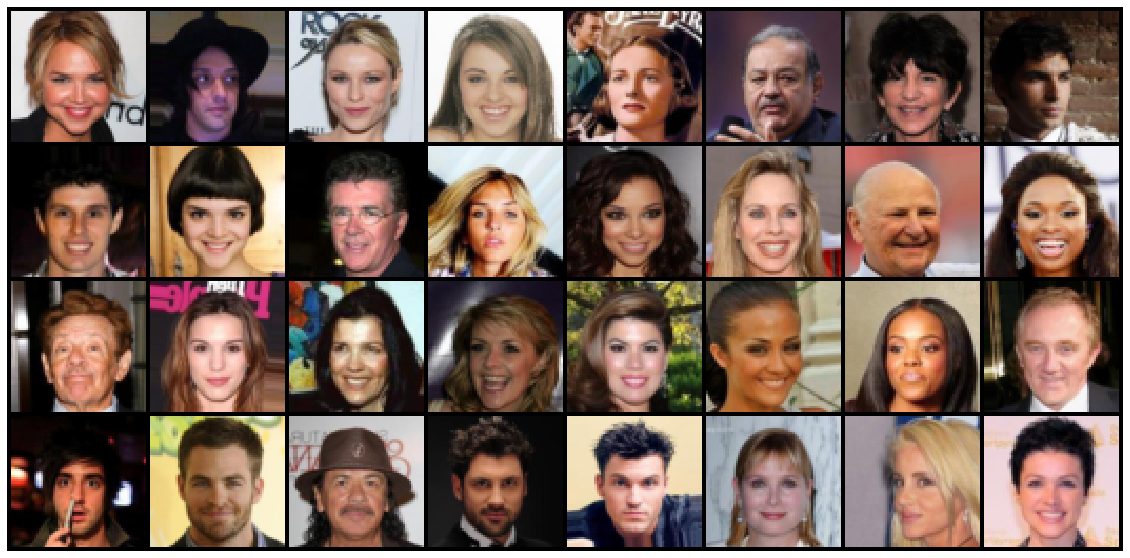

In [ ]:
images_cnt = 32
    
plt.imshow(
    make_grid(
        [
            denormalize(dataset[np.random.randint(len(dataset))][0])
            for idx in range(images_cnt)
        ]
    )
    .permute(1, 2, 0)
    .numpy(), aspect='auto', interpolation='nearest'
)
plt.axis("off")
plt.show()

In [ ]:
domains = ['Male', 'Oval_Face', 'Young', 'Smiling', 'Blond_Hair', 'Mustache', 'Wearing_Hat', 'Eyeglasses', 'Big_Nose', 'Bags_Under_Eyes']
assert set(domains).issubset(set(dataset.header))
domains_idx = [dataset.header.index(f) for f in domains]
print(*zip(domains_idx, domains), sep = '\n')
args.num_domains = len(domains)
assert args.num_domains >= 10

(20, 'Male')
(25, 'Oval_Face')
(39, 'Young')
(31, 'Smiling')
(9, 'Blond_Hair')
(22, 'Mustache')
(35, 'Wearing_Hat')
(15, 'Eyeglasses')
(7, 'Big_Nose')
(3, 'Bags_Under_Eyes')


# Этап 2. Обучение модели
В рамках данного задания предлагается реализовать и обучить StarGAN для генережки лиц с заданными аттрибутами
![](https://github.com/HSE-LAMBDA/DeepGenerativeModels/blob/spring-2023/homework/second/assets/stargan.png?raw=1)

Вам на выбор предлагается реализовать [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**) или [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

In [ ]:
device

device(type='cuda')

In [ ]:
##
# Generator
##


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=3, stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(channels, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                channels, channels, kernel_size=3, stride=1, padding=1, bias=False
            ),
            nn.BatchNorm2d(channels, affine=True, track_running_stats=True),
        )

    def forward(self, x):
        return x + self.conv_block(x)
        


class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DownsampleBlock, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.BatchNorm2d(out_channels, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.network(x)


class UpsampleBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride, padding, last=False
    ):
        super(UpsampleBlock, self).__init__()
        self.network = [
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
        ]
        if not last:
            self.network += [
                nn.BatchNorm2d(out_channels, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ]
        self.network = nn.Sequential(*self.network)

    def forward(self, x):
        return self.network(x)


class Generator(nn.Module):
    def __init__(self, image_size, num_domains, num_channels=3, bottleneck_size=6):
        super(Generator, self).__init__()
        self.num_domains = num_domains

        self.downsample = nn.Sequential(
            DownsampleBlock(
                in_channels=num_channels + num_domains,
                out_channels=64,
                kernel_size=7,
                stride=1,
                padding=3,
            ),
            DownsampleBlock(
                in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1
            ),
            DownsampleBlock(
                in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1
            ),
        )
        self.bottleneck = nn.Sequential(
            *[ResidualBlock(256) for idx in range(bottleneck_size)]
        )
        self.upsample = nn.Sequential(
            UpsampleBlock(
                in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1
            ),
            UpsampleBlock(
                in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1
            ),
            UpsampleBlock(
                in_channels=64,
                out_channels=num_channels,
                kernel_size=7,
                stride=1,
                padding=3,
                last=True,
            ),
            nn.Tanh(),
        )

    # batch_size x 3 x image_size x image_size, batch_size x num_domains
    def forward(self, x, c):
        c = c[(..., ) + (None, ) * 2].repeat(1, 1, x.shape[2], x.shape[3])

#         c = c.reshape(*c.size(), 1, 1).repeat(1, 1, *x.size()[-2:])
        x = torch.cat([x, c], dim=1)
        x = self.downsample(x)
        x = self.bottleneck(x)
        x = self.upsample(x)
        return x


##
# Discriminator
##


class HiddenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, negative_slope=0.01):
        super(HiddenBlock, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.LeakyReLU(negative_slope=negative_slope),
        )

    def forward(self, x):
        return self.network(x)


class Discriminator(nn.Module):
    def __init__(self, image_size, num_domains, num_channels=3, hidden_layers_count=5):
        super(Discriminator, self).__init__()
        self.num_domains = num_domains

        self.input_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.LeakyReLU(negative_slope=0.01),
        )
        self.hidden_layer = nn.Sequential(
            *[
                HiddenBlock(64 * (2**idx), 2 * (64 * 2 ** (idx)))
                for idx in range(hidden_layers_count)
            ]
        )
        image_size //= 2 ** (hidden_layers_count + 1)

        self.conv_pred = nn.Sequential(
            nn.Conv2d(
                in_channels=64 * (2**hidden_layers_count),
                out_channels=1,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
#             nn.AvgPool2d(kernel_size=image_size // 2),
        )
        self.conv_class = nn.Conv2d(
            in_channels=64 * (2**hidden_layers_count),
            out_channels=num_domains,
            kernel_size=image_size,
            stride=1,
            padding=0,
            bias=False,
        )

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        return self.conv_pred(x).reshape(x.size(0), -1), self.conv_class(x).reshape(
            x.size(0), -1
        )


In [ ]:
from numba import cuda 
cuda.get_current_device().reset()
# torch.cuda.empty_cache()
import gc
gc.collect()
# del generator, discriminator

23

In [ ]:
# Sanity check

image_size = 64
batch_size = 16
domains_count = 10

x = torch.randn(batch_size, 3, image_size, image_size).to(device)
c = torch.randint(2, size=(batch_size, domains_count)).to(device) - 1. 
gen = Generator(image_size, domains_count).to(device)
fake = gen.forward(x, c)
assert fake.shape == (batch_size, 3, image_size, image_size)

disc = Discriminator(image_size, domains_count).to(device)
pred, class_pred = disc.forward(fake)

# PatchGAN возвращает несколько чисел
assert pred.shape[:1] == (batch_size, )

assert class_pred.shape == (batch_size, domains_count)

del gen, disc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_checkpoint = '/content/drive/MyDrive/trainv8'
logfile = f'{base_checkpoint}/train.log'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir /content/drive/MyDrive/trainv8
!touch /content/drive/MyDrive/trainv8/train.log
!echo 'Adam + 0.0002 + nofuzzing + batchnorm(fixed) + BS32' >> /content/drive/MyDrive/trainv8/readme.md

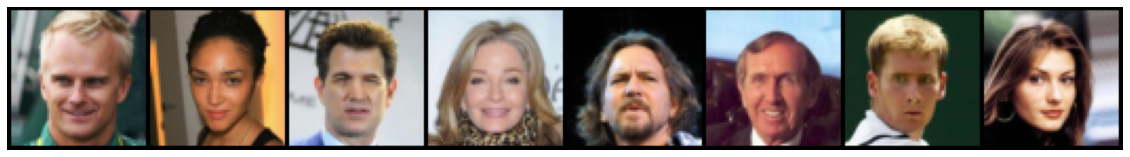

In [ ]:
#!g1.1
visualise_count = 8
visualise_idx = [12, 13, 14, 17, 19, 20, 89, 1266]
visualise_images = torch.stack([dataset[idx][0] for idx in visualise_idx])

plt.imshow(
    make_grid( [ denormalize(img) for img in visualise_images ] )
    .permute(1, 2, 0)
    .numpy()
)
plt.axis("off")
plt.show()


def visualize_generator(generator, show=False):
    rows = [make_grid( [ denormalize(img) for img in visualise_images ] )]
    with torch.no_grad():
        for i, (idx, name) in enumerate(zip(domains_idx, domains)):
            c = torch.zeros(visualise_count, args.num_domains)
            c[:,i]=1

            fake_x = generator.forward(visualise_images, c)
            rows.append(make_grid( [ denormalize(img) for img in fake_x ] ))
   
    plt.figure(figsize = (20,20))
    image = make_grid(rows, nrow=1).permute(1, 2, 0).numpy()
    if show:
        plt.imshow(image, interpolation='nearest')
        plt.axis("off")
        plt.show()
    plt.imsave(f"{base_checkpoint}/image{str(datetime.utcnow().strftime('%Y-%m-%d_%H:%M:%S.%f')[:-3])}.png", image)

In [ ]:
generator = Generator(args.image_size, args.num_domains).to(device)
discriminator = Discriminator(args.image_size, args.num_domains).to(device)

In [32]:
num_epochs = 20

generator_optim = torch.optim.Adam(generator.parameters(), 0.0002, betas=(0.5, 0.999))
discriminator_optim = torch.optim.Adam(discriminator.parameters(), 0.0002, betas=(0.5, 0.999))

lr_lambda = lambda iteration: 1.0 if iteration < num_epochs / 2 else 1.0 - (iteration - (num_epochs / 2)) / (num_epochs / 2)

generator_scheduler = LambdaLR(generator_optim, lr_lambda = lr_lambda)
discriminator_scheduler = LambdaLR(discriminator_optim, lr_lambda = lr_lambda)

lambda_cls = 1.
lambda_rec = 10.
lambda_gp = 10.
discriminator_per_generator = 5

batch_count = len(dataloader)

for epoch in tqdm(range(num_epochs)):
    pbar = tqdm(total=batch_count, position=0, leave=True)
    for batch_id, (x_true, y_true) in enumerate(dataloader):
        # print(f"{batch_id + 1}\t/\t{batch_count}", end = ":\t")
        # if (batch_id == 100):
        #     break
        x_true = x_true.to(device)

        y_true = (y_true['attributes'][:,domains_idx] == 1).float()
        
        x_true = x_true[y_true.sum(dim=1) > 0]
        y_true = y_true[y_true.sum(dim=1) > 0]

        # y_true[y_true == 0] += torch.rand(y_true.shape)[y_true == 0] * 0.1
        # y_true[y_true == 1] -= torch.rand(y_true.shape)[y_true == 1] * 0.1

        y_true = y_true.to(device)
        
        if len(x_true) == 0:
            continue
        
        y_fake = y_true[torch.randperm(len(y_true))].float().to(device)

        with torch.no_grad():
            x_fake = generator(x_true, y_fake).detach()
        true_predict, true_domains = discriminator(x_true)
        fake_predict, fake_domains = discriminator(x_fake)

        # FIXME!
        # l_adv = torch.mean(true_prefict) - torch.mean(fake_predict)
        x_hat = (x_fake + x_true) / 2.

        alpha = torch.tile(torch.rand(x_fake.size(0)), (3, args.image_size, args.image_size, 1)).permute(3, 0, 1, 2).to(device)
        x_hat = (x_fake * alpha + (1 - alpha) * x_true).requires_grad_(True)
        x_hat_pred, x_hat_domains = discriminator(x_hat)
        x_hat_pred_grad = torch.autograd.grad(outputs=x_hat_pred, inputs=x_hat, grad_outputs=torch.ones(x_hat_pred.size()).to(device), retain_graph = True, create_graph=True, only_inputs=True)[0]
        l_gp = ((x_hat_pred_grad.view(x_hat.size(0), -1).norm(2, dim=1) - 1.)**2).mean()
        # Hack!
        l_adv = torch.mean(true_predict) - torch.mean(fake_predict) - l_gp * lambda_gp

        l_r_cls = F.binary_cross_entropy_with_logits(true_domains, y_true, size_average=False) / len(x_fake)


        discriminator_loss = -l_adv + lambda_cls * l_r_cls


        with open(logfile, 'a') as f:
            print(epoch, batch_id, 'DESC', discriminator_loss.item(), l_adv.item(), l_r_cls.item(), sep='\t', file=f)

        discriminator.zero_grad()
        generator.zero_grad()

        discriminator_loss.backward()
        discriminator_optim.step()
        
        if batch_id % discriminator_per_generator + 1 == discriminator_per_generator:
            x_fake = generator(x_true, y_fake)

            fake_predict, fake_domains = discriminator(x_fake)

            l_adv = -torch.mean(fake_predict)

            l_f_cls = F.binary_cross_entropy_with_logits(fake_domains, y_fake, size_average=False) / len(x_fake)

            x_recon = generator(x_fake, y_true)

            l_rec = torch.mean(abs(x_recon - x_true))

            generator_loss = l_adv + lambda_cls * l_f_cls + lambda_rec * l_rec

            with open(logfile, 'a') as f:
                print(epoch, batch_id, 'GEN', generator_loss.item(), l_adv.item(), l_rec.item(), l_f_cls.item(), sep='\t', file=f)

            discriminator.zero_grad()
            generator.zero_grad()
            generator_loss.backward()
            generator_optim.step()
        
        pbar.update(1)
        if batch_id % 300 == 0:
            visualize_generator(generator.cpu())
            generator.to(device)
    pbar.close()

    gen_checkpoint_path = f"{base_checkpoint}/generator_epoch_{epoch}.ckpt"
    torch.save(generator.state_dict(), gen_checkpoint_path)

    disc_checkpoint_path = f"{base_checkpoint}/discriminator_epoch_{epoch}.ckpt"
    torch.save(discriminator.state_dict(), disc_checkpoint_path)

    generator_scheduler.step()
    discriminator_scheduler.step()
    
    print("Iteration: {}, Learning Rate: {}".format(epoch, generator_scheduler.get_last_lr()))





  0%|          | 0/6332 [00:16<?, ?it/s]
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
 95%|█████████▍| 6001/6332 [08:39<00:27, 12.12it/s]<ipython-input-26-d9c16cc713b0>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (20,20))
100%|██████████| 6332/6332 [09:09<00:00, 11.53it/s]

  5%|▌         | 1/20 [09:09<2:54:06, 549.81s/it]

Iteration: 0, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:09<00:00, 11.52it/s]

 10%|█         | 2/20 [18:19<2:45:00, 550.03s/it]

Iteration: 1, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:09<00:00, 11.52it/s]

 15%|█▌        | 3/20 [27:30<2:35:50, 550.05s/it]

Iteration: 2, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:11<00:00, 11.48it/s]

 20%|██        | 4/20 [36:42<2:26:52, 550.79s/it]

Iteration: 3, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:04<00:00, 11.62it/s]

 25%|██▌       | 5/20 [45:47<2:17:12, 548.85s/it]

Iteration: 4, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:03<00:00, 11.64it/s]

 30%|███       | 6/20 [54:51<2:07:42, 547.30s/it]

Iteration: 5, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:17<00:00, 11.35it/s]

 35%|███▌      | 7/20 [1:04:10<1:59:22, 550.94s/it]

Iteration: 6, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:04<00:00, 11.64it/s]

 40%|████      | 8/20 [1:13:14<1:49:47, 548.96s/it]

Iteration: 7, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:03<00:00, 11.64it/s]

 45%|████▌     | 9/20 [1:22:19<1:40:22, 547.51s/it]

Iteration: 8, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:03<00:00, 11.64it/s]

 50%|█████     | 10/20 [1:31:23<1:31:05, 546.58s/it]

Iteration: 9, Learning Rate: [0.0002]


100%|██████████| 6332/6332 [09:07<00:00, 11.57it/s]

 55%|█████▌    | 11/20 [1:40:31<1:22:02, 546.99s/it]

Iteration: 10, Learning Rate: [0.00018]


100%|██████████| 6332/6332 [09:09<00:00, 11.53it/s]

 60%|██████    | 12/20 [1:49:41<1:13:02, 547.85s/it]

Iteration: 11, Learning Rate: [0.00016]


100%|██████████| 6332/6332 [09:08<00:00, 11.55it/s]

 65%|██████▌   | 13/20 [1:58:50<1:03:57, 548.15s/it]

Iteration: 12, Learning Rate: [0.00014]


100%|██████████| 6332/6332 [09:08<00:00, 11.55it/s]

 70%|███████   | 14/20 [2:07:58<54:49, 548.31s/it]  

Iteration: 13, Learning Rate: [0.00012]


100%|██████████| 6332/6332 [09:08<00:00, 11.55it/s]

 75%|███████▌  | 15/20 [2:17:07<45:41, 548.39s/it]

Iteration: 14, Learning Rate: [0.0001]


100%|██████████| 6332/6332 [09:08<00:00, 11.54it/s]

 80%|████████  | 16/20 [2:26:16<36:34, 548.69s/it]

Iteration: 15, Learning Rate: [8e-05]


100%|██████████| 6332/6332 [09:08<00:00, 11.54it/s]

 85%|████████▌ | 17/20 [2:35:26<27:26, 548.90s/it]

Iteration: 16, Learning Rate: [6.0000000000000015e-05]


 85%|████████▌ | 17/20 [2:35:29<27:26, 548.77s/it]


KeyboardInterrupt: ignored

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [ ]:
# # Pretrained model

# !gdown --id 1YROZScl13nofq4JtLP5LdofLbufu8jlC
# !gdown --id 1YOTJ7qgAtV3zqPbV9sV01NQbVbWOjCSY

# generator.load_state_dict(torch.load(f'generator_epoch_16.ckpt', map_location=device))
# generator.to(device)
# generator.train()

# discriminator.load_state_dict(torch.load(f'discriminator_epoch_16.ckpt', map_location=device))
# discriminator.to(device)
# discriminator.train()

# visualize_generator(generator.cpu(), True)
# generator.to(device)

# Evaluation

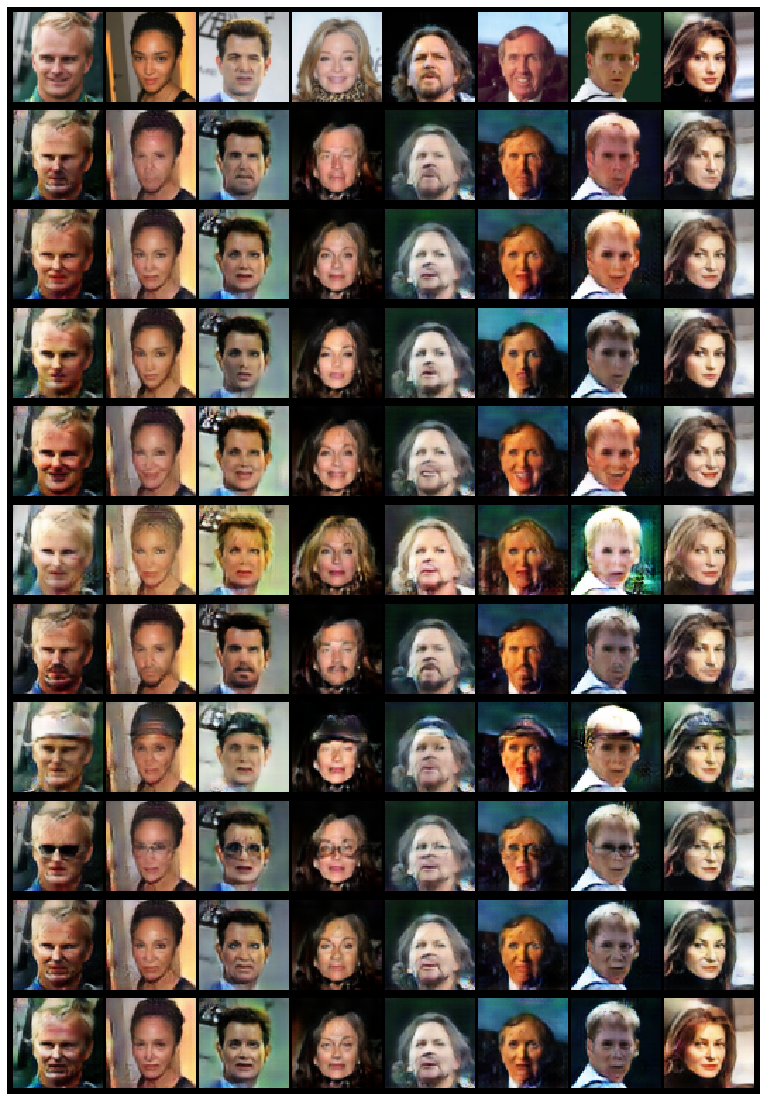

In [43]:
visualize_generator(generator.cpu(), True)
generator.to(device)
print()

In [57]:
lpips = LPIPS()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

In [40]:
a = torch.zeros(2, 2)
a[[1, 0], np.arange(2)]=1
a

tensor([[0., 1.],
        [1., 0.]])

In [60]:
from tqdm.auto import trange
test_iters = 100
values = []
for i in trange(test_iters):
    # fetch images and labels
    x_real, _ = next(iter(dataloader))
    x_real.float().to(device)
    y_trg = torch.zeros(x_real.shape[0], args.num_domains).to(device)

    batch_size = x_real.shape[0]
    y_trg[np.arange(batch_size), np.random.choice(np.arange(args.num_domains), size=batch_size)] = 1.

    
    with torch.no_grad():
        x_fake = generator(x_real.to(device), y_trg.to(device))

    values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())

assert(np.mean(values) < 1.3)
# :(

  0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: ignored

# Этап 3(\*). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **2 балла**
* Текстовое ревью решения и предложения возможных улучшений - **1 балл**

Отчёт по ссылке: https://drive.google.com/file/d/1khlGDefliE_X9YXf74SWGSURi8SQqPjv/view?usp=sharing 
Ниже -- то, как получил картинки из отчёта и график обучения

(Сори, что всё так криво)

torch.Size([1, 3, 64, 64]) torch.Size([1, 10])
torch.Size([1, 3, 64, 64]) torch.Size([1, 10])
torch.Size([1, 3, 64, 64]) torch.Size([1, 10])
torch.Size([1, 3, 64, 64]) torch.Size([1, 10])
torch.Size([1, 3, 64, 64]) torch.Size([1, 10])
torch.Size([1, 3, 64, 64]) torch.Size([1, 10])
torch.Size([1, 3, 64, 64]) torch.Size([1, 10])


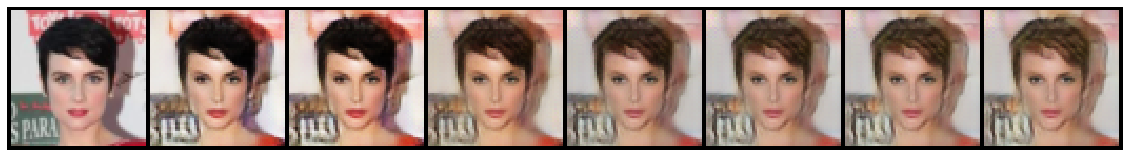

In [98]:
img, c = dataset[1237]
start = (c['attributes'][domains_idx] == 1).float()
end = start.clone()
start[domains.index('Blond_Hair')] = 1

rows = [denormalize(img.cpu())]
steps = 7
with torch.no_grad():
    for alpha in (np.arange(steps) / steps)[::-1]:
        target = (end * alpha + start * (1 - alpha))[None,:]
        fake_x = generator.forward(img[None,:,:,:].to(device), target.to(device))
        rows.append(denormalize(fake_x[0].cpu()))
   
image = make_grid(rows, nrow=steps + 1).permute(1, 2, 0).numpy()
plt.figure(figsize = (20,20))
plt.imshow(image, interpolation='nearest')
plt.axis("off")
plt.show()


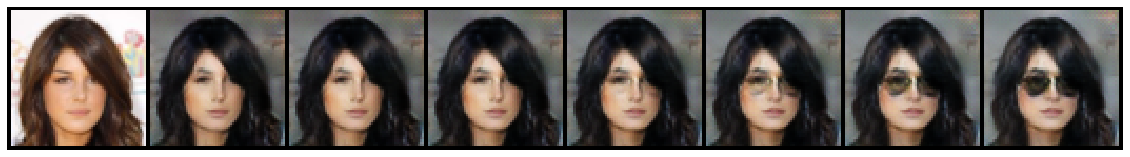

In [103]:
img, c = dataset[131228]
start = (c['attributes'][domains_idx] == 1).float()
end = start.clone()
start[domains.index('Eyeglasses')] = 1 - start[domains.index('Eyeglasses')]

rows = [denormalize(img.cpu())]
steps = 7
with torch.no_grad():
    for alpha in (np.arange(steps) / steps)[::-1]:
        target = (end * alpha + start * (1 - alpha))[None,:]
        fake_x = generator.forward(img[None,:,:,:].to(device), target.to(device))
        rows.append(denormalize(fake_x[0].cpu()))
   
image = make_grid(rows, nrow=steps + 1).permute(1, 2, 0).numpy()
plt.figure(figsize = (20,20))
plt.imshow(image, interpolation='nearest')
plt.axis("off")
plt.show()


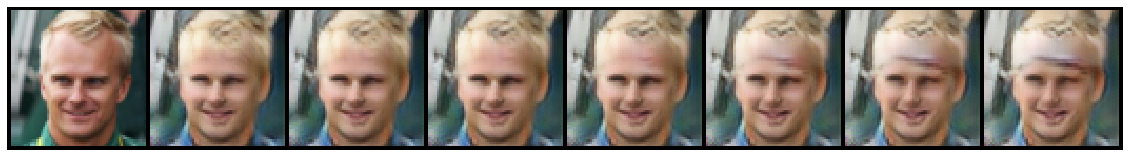

In [104]:
img, c = dataset[12]
start = (c['attributes'][domains_idx] == 1).float()
end = start.clone()
start[domains.index('Wearing_Hat')] = 1 - start[domains.index('Wearing_Hat')]

rows = [denormalize(img.cpu())]
steps = 7
with torch.no_grad():
    for alpha in (np.arange(steps) / steps)[::-1]:
        target = (end * alpha + start * (1 - alpha))[None,:]
        fake_x = generator.forward(img[None,:,:,:].to(device), target.to(device))
        rows.append(denormalize(fake_x[0].cpu()))
   
image = make_grid(rows, nrow=steps + 1).permute(1, 2, 0).numpy()
plt.figure(figsize = (20,20))
plt.imshow(image, interpolation='nearest')
plt.axis("off")
plt.show()


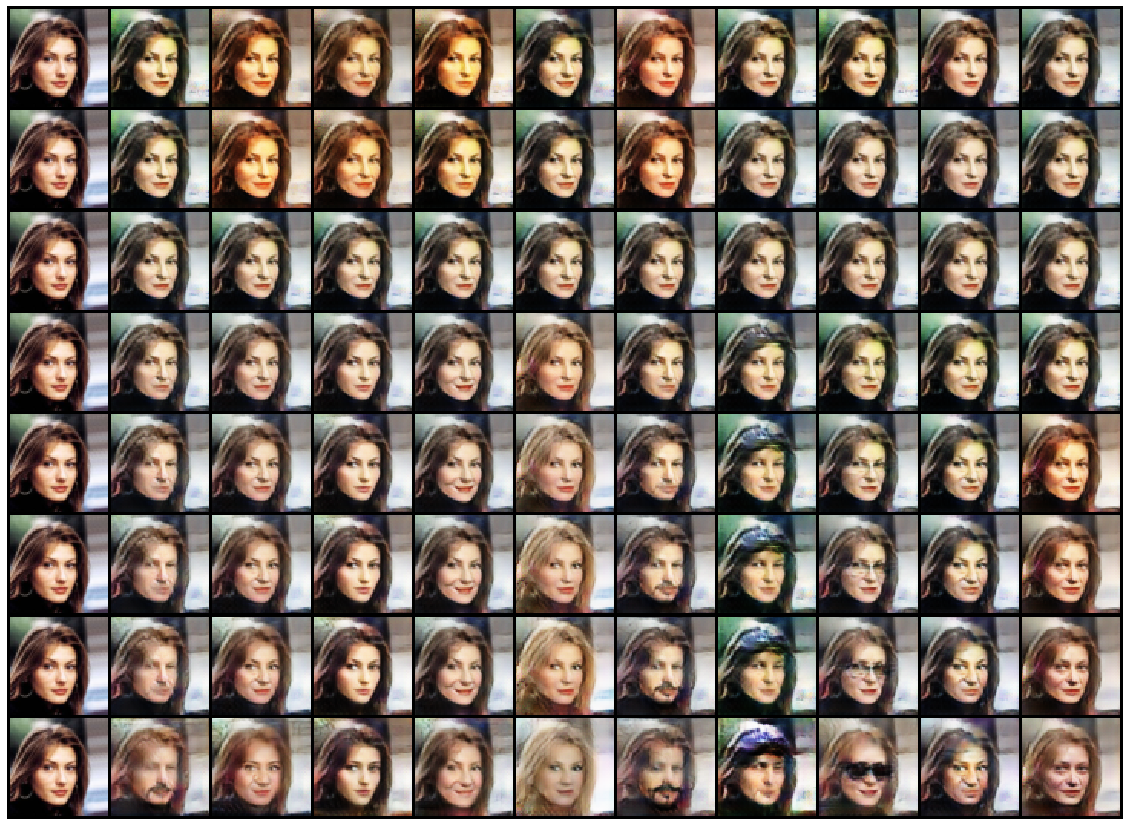

In [124]:
img, c = dataset[1266]
start = (c['attributes'][domains_idx] == 1).float()

rows = []
with torch.no_grad():
    for degree in [-1, -0.5, 0, 0.5, 1, 1.5, 2, 5]:
        row = [denormalize(img.cpu())]
        for i, (idx, name) in enumerate(zip(domains_idx, domains)):
            c = torch.zeros(len(domains_idx))
            c[i]=degree

            fake_x = generator.forward(img[None,:,:,:].to(device), c[None,:].to(device))
            row.append(denormalize(fake_x)[0].cpu())
        rows += row

plt.figure(figsize = (20,20))
image = make_grid(rows, nrow=len(domains_idx) + 1).permute(1, 2, 0).numpy()
plt.imshow(image, interpolation='nearest')
plt.axis("off")
plt.show()


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
!gdown --id 1YW2RPmkJ201trV_J0QeJuLwGVeuWXo2z
!cat train.log | grep DESC > desc
!cat train.log | grep GEN > gen

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YW2RPmkJ201trV_J0QeJuLwGVeuWXo2z
To: /content/train.log
100% 9.29M/9.29M [00:00<00:00, 79.6MB/s]


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


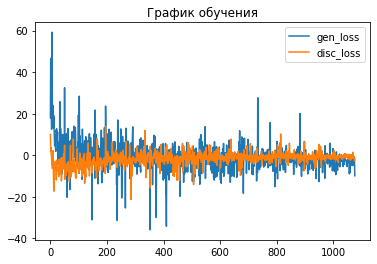

In [27]:
gendf = pd.read_csv('gen', delimiter='\t', warn_bad_lines=False, error_bad_lines=False,)
descdf = pd.read_csv('desc', delimiter='\t', warn_bad_lines=False, error_bad_lines=False,)

plt.plot(gendf.to_numpy()[:,3][::20], label='gen_loss')
plt.plot(descdf.to_numpy()[:,3][::100], label='disc_loss')
plt.legend()
plt.title('График обучения') 
plt.show()